## Modules

In [ ]:
from pyspark import SparkContext, SparkConf, HiveContext
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

## Context SPARK

In [1]:
# Quelques Param de Conf
conf = SparkConf()
conf = conf.set('spark.sql.shuffle.partitions', '4')
conf = conf.setMaster('local[*]')
conf = conf.setAppName('K-MEANS')
conf = conf.set('spark.ui.port', '5050')

# Demarrage du Context SPARK
sc = SparkContext(conf=conf )
#Create HiveContext
hctx = HiveContext(sc)

## Data

In [26]:
hctx.sql("USE Default")
df = hctx.sql("SELECT * FROM dts_mod_rcu")
rdd = df.rdd                            # transformation en  rdd
rdd.persist()                           # persister les données
df.show(3)

+--------------------+--------------+------+-----------------+------------------+--------------------+-----------------------+-------------------------+---------------------+-----------------------+-----------------------+-------------------------+---------------+-----------------------+-------------------------+---------------+--------------------+----------------------------+------------------------------+-------------------------+----------+------------------+--------------------+---------------+-------------+---------------------+-----------------------+------------------+------------+--------------------+----------------------+-----------------+------------+--------------------+----------------------+-----------------+-----------------------+-------------------------------+---------------------------+----------------------------+-----------------+--------------------+--------------------+--------------------+-------+----------------------+----------------+
|     code_client_rcu|nb

In [5]:
df = hctx.sql("SELECT code_client_rcu, age_fin ,nb_personnes_foyer_fin,ca_cli,  nb_tickets_bio_cli, nb_tickets_epicerie_cli FROM dts_mod_rcu WHERE nb_tickets_cli > 0")
df = df.persist()
df.count()

99999

In [7]:
df.printSchema()

root
 |-- code_client_rcu: string (nullable = true)
 |-- age_fin: double (nullable = true)
 |-- nb_personnes_foyer_fin: double (nullable = true)
 |-- ca_cli: double (nullable = true)
 |-- nb_tickets_bio_cli: long (nullable = true)
 |-- nb_tickets_epicerie_cli: long (nullable = true)



In [24]:
varList=[]

for c in df.dtypes:
    if (c[1]=="string" and c[0]<>'code_client_rcu' or 'part' in c[0]):
        print 'droping (0)'.format(c)
        df=df.drop(c[0])
    elif c[0] <>'code_client_rcu':
        varList.append(c[0])
        
for c in df.columns :
    df.select(c).describe().show()

+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+

+-------+------------------+
|summary|           age_fin|
+-------+------------------+
|  count|             99999|
|   mean| 67.81340180138943|
| stddev|18.091855579018485|
|    min|               0.0|
|    max|             117.0|
+-------+------------------+

+-------+----------------------+
|summary|nb_personnes_foyer_fin|
+-------+----------------------+
|  count|                 99999|
|   mean|     2.029079501982773|
| stddev|    0.9527678108409923|
|    min|                   1.0|
|    max|                   5.0|
+-------+----------------------+

+-------+--------------------+
|summary|              ca_cli|
+-------+--------------------+
|  count|               99999|
|   mean|  325.89332653326414|
| stddev|   436.3827548810032|
|    min|-0.01000000000000334|
|    max|            17654.93|
+-------+--------------------+

+-------+------------------+
|summary|nb_tickets_bio_cli|
+-------+--

In [6]:
df.describe().show()

+-------+------------------+----------------------+--------------------+------------------+-----------------------+
|summary|           age_fin|nb_personnes_foyer_fin|              ca_cli|nb_tickets_bio_cli|nb_tickets_epicerie_cli|
+-------+------------------+----------------------+--------------------+------------------+-----------------------+
|  count|             99999|                 99999|               99999|             99999|                  99999|
|   mean| 67.81340180138943|     2.029079501982773|  325.89332653326414|0.5386553865538656|      5.515285152851528|
| stddev|18.091855579018485|    0.9527678108409923|   436.3827548810032|1.6541396554078422|      4.772758054922473|
|    min|               0.0|                   1.0|-0.01000000000000334|                 0|                      0|
|    max|             117.0|                   5.0|            17654.93|                46|                     58|
+-------+------------------+----------------------+--------------------+

In [7]:
df=df.na.fill(0.0)

## Data preparaton

In [9]:
data = df.rdd.map(lambda x :(x[0], Vectors.dense(x[1:])))
data.first()

(u'16190581', DenseVector([90.0, 2.0, 201.47, 0.0, 5.0]))

In [14]:
key = df.rdd.map(lambda x: (x[0]))
key.take(5)

[u'16190581', u'A2274157', u'A2101873', u'I0356097', u'A3677499']

In [9]:
features = df.rdd.map(lambda x : (x[1:]))
features.take(5)

[(90.0, 2.0, 201.47, 0, 5),
 (45.0, 4.0, 38.0, 0, 1),
 (68.65195349421322, 1.94120441631986, 36.0, 0, 1),
 (60.0, 2.251710553597346, 27.9, 0, 1),
 (54.0, 2.0, 37.43000000000001, 0, 1)]

Centrer et réduire les variables

In [12]:
scaler = StandardScaler(withStd=True, withMean=True).fit(features)
stdfeat = scaler.transform(features) 
stdfeat.take(5)

[DenseVector([1.2263, -0.0305, -0.2851, -0.3256, -0.108]),
 DenseVector([-1.261, 2.0686, -0.6597, -0.3256, -0.9461]),
 DenseVector([0.0463, -0.0922, -0.6643, -0.3256, -0.9461]),
 DenseVector([-0.4319, 0.2337, -0.6829, -0.3256, -0.9461]),
 DenseVector([-0.7635, -0.0305, -0.661, -0.3256, -0.9461])]

In [15]:
##Zip complete RDD
data = key.zip(stdfeat)
data = data.repartition(4)
data.take(5)

[(u'A2013402', DenseVector([-0.1002, -1.0801, -0.4487, 0.2789, -0.3175])),
 (u'I0151601', DenseVector([0.0463, -0.0922, -0.085, 3.3016, 0.9396])),
 (u'62170496', DenseVector([0.1209, -1.0801, 0.0728, -0.3256, 0.3111])),
 (u'A0390146', DenseVector([0.8947, -1.0801, 6.1468, -0.3256, 4.292])),
 (u'A4002569', DenseVector([0.0036, -0.0203, -0.6521, -0.3256, -0.9461]))]

In [14]:
data = data.persist()
data.count()

99999

## Choix du k

In [16]:
def error(clusters, point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point-center)]))

In [16]:
outPut = []
xk = []

for k in range(2, 10):
    clusters = KMeans.train(data.map(lambda x: (x[1])),\
                           k,\
                           maxIterations=100,\
                           initializationMode="k-means||",\
                           seed=12345,\
                           initializationSteps=5,\
                           epsilon=1e-4)

    WSSSE = (data.map(lambda x: (x[1]))\
            .map(lambda x: error(clusters, x))\
            .reduce(lambda x, y: x + y))

    outPut.append(WSSSE)
    xk.append(k)
    
    print("\t- WSSSE for K({0})-means = {1}".format(k, WSSSE))

	- WSSSE for K(2)-means = 154421.289206
	- WSSSE for K(3)-means = 141464.998009
	- WSSSE for K(4)-means = 136972.347816
	- WSSSE for K(5)-means = 120123.044864
	- WSSSE for K(6)-means = 115696.0413
	- WSSSE for K(7)-means = 108863.229766
	- WSSSE for K(8)-means = 107182.830122
	- WSSSE for K(9)-means = 102897.261869


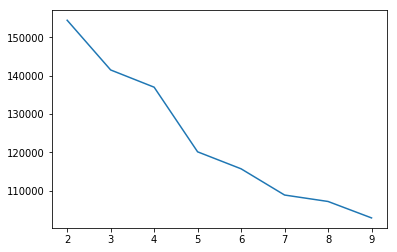

In [17]:
plt.plot(xk,outPut)
plt.show()

In [17]:
clusters = KMeans.train(data.map(lambda x: (x[1])),\
                       5,\
                       maxIterations=100,\
                       initializationMode="random",\
                       seed=12345,\
                       initializationSteps=5,\
                       epsilon=1e-3)

print clusters.clusterCenters

[array([ 1.03870784, -0.58856496, -0.14729008, -0.12733411,  0.00146062]), array([-0.3835678 , -0.08313784, -0.45778935, -0.2020885 , -0.58952305]), array([ 0.3007807 , -0.35882723,  1.14243284,  0.14379107,  1.38913912]), array([ 0.38054644, -0.3274483 ,  2.50516282,  4.8601208 ,  2.00998326]), array([-1.15454073,  2.19175133, -0.21246968, -0.18310696, -0.27797803])]


## Exportation du Model

In [ ]:
# Sauvegarde du model sur le HDFS
clusters.save(sc,"/user/hadoop/MODELS/kmeans_01")

In [ ]:
# Chargement du model
model = KMeansModel.load(sc, "/user/hadoop/MODELS/kmeans_01")

model

In [20]:
KMeans.train(data.map(lambda x: (x[1])),\
                       5,\
                       maxIterations=100,\
                       #initializationMode="random",\
                       seed=12345,\
                       initializationSteps=5,\
                       initialModel = model,
                       epsilon=1e-3)

In [21]:
output = data.map(lambda x: x[0]).zip(clusters.predict(data.map(lambda y: (y[1]))))\
.toDF(["code_client_rcu", "cluster"])

In [22]:
final = df.join(output, ["code_client_rcu"])
final.groupBy("cluster").count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      2|17990|
|      4|11227|
|      1|45279|
|      0|23124|
|      3| 2379|
+-------+-----+



## Cluster and Interpretability

In [25]:
for i in range(0, len(clusters.clusterCenters)):
    print("\n--cluster {0} description".format(i))
    print(final.filter("cluster={0}".format(i)).describe(varList).show())


--cluster 0 description
+-------+------------------+----------------------+------------------+------------------+-----------------------+
|summary|           age_fin|nb_personnes_foyer_fin|            ca_cli|nb_tickets_bio_cli|nb_tickets_epicerie_cli|
+-------+------------------+----------------------+------------------+------------------+-----------------------+
|  count|             23124|                 23124|             23124|             23124|                  23124|
|   mean|  86.6020356162834|     1.468388633001917| 261.6443037536756|0.3281439197370697|      5.523482096523093|
| stddev|14.425896448786443|    0.6032527751162192|153.81009163858897|0.7975995409765995|      2.641737403522946|
|    min|              61.0|                   1.0|0.9900000000000092|                 0|                      0|
|    max|             117.0|                   5.0|           1065.32|                 6|                     14|
+-------+------------------+----------------------+------------